# 4. Improve Results

From https://machinelearningmastery.com/process-for-working-through-machine-learning-problems/

After spot checking, it’s time to squeeze out the best result from the rig. I do this by running an automated sensitivity analysis on the parameters of the top performing algorithms. I also design and run experiments using standard ensemble methods of the top performing algorithms. I put a lot of time into thinking about how to get more out of the dataset or of the family of algorithms that have been shown to perform well.

Again, statistical significance of results is critical here. It is so easy to focus on the methods and play with algorithm configurations. The results are only meaningful if they are significant and all configuration are already thought out and the experiments are executed in batch. I also like to maintain my own personal leaderboard of top results on a problem.

In summary, the process of improving results involves:

* Algorithm Tuning: where discovering the best models is treated like a search problem through model parameter space.
* Ensemble Methods: where the predictions made by multiple models are combined.
* Extreme Feature Engineering: where the attribute decomposition and aggregation seen in data preparation is pushed to the limits.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
%matplotlib inline

 * [Training and submission data](#Training-and-submission-data)
 * [Model checking](#Model-checking)
   * [Linear regression](#Linear-regression)
   * [Plotting target indicator](#Plotting-target-indicator)
   * [Polynomial model setup (12/06/2019)](#Polynomial-model-setup-(12/06/2019))
      * [Polynomial regression baseline](#Polynomial-regression-baseline)
* [Using multivariate indicators](#Using-multivariate-indicators)
    * [Cross correlation](#Cross-correlation)
    * [VAR](#VAR)

## Training and submission data

In [3]:
df = pd.read_csv('data/TrainingSet.csv', index_col=0)
df.columns = [year[:4] for year in df.columns][:-3] + [col.replace(' ', '_') for col in df.columns.values[-3:]]

In [4]:
# read the data containing the rows we need to predict
df_submission = pd.read_csv('data/SubmissionRows.csv', index_col=0)

In [5]:
df_submission_in_data = df.loc[df_submission.index]
submission_codes = df_submission_in_data.Series_Code.unique()

## Model checking

 * We have 737 indicators from 206 countries with data from 1972 to 2007.
 * We would like to predict what these indicators will be in 2008 and 2012.

### Linear regression

A very simplistic way of predicting the future values of these indicators would be to do a simple linear regression for indicators with more than 1 data point in the last 35 years or use the only data point we have for indicators with a single value.

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
def make_prediction(row):
    data = row.loc['1972':'2007']
    nbr_data_points = data.count()
    if nbr_data_points < 2:
        pred_2008 = data.dropna().values
        pred_2012 = pred_2008
    
    else:
        years = data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = data.dropna().values
        
        # linear regression
        regr = LinearRegression()
        regr.fit(years, values)
        
        # predictions
        pred_2008 = regr.predict(np.array([2008]).reshape(-1, 1))
        pred_2012 = regr.predict(np.array([2012]).reshape(-1, 1))
        
    return pred_2008[0], pred_2012[0]

In [8]:
df_simple_preds = pd.DataFrame(df_submission_in_data.apply(make_prediction, axis=1).tolist(), \
                               index=df_submission_in_data.index, columns=['2008','2012'])

In [9]:
df_simple_preds.head()

2008      2012
559   0.465706  0.580451
618   0.012712  0.016830
753   0.087664  0.065155
1030  0.001000  0.001000
1896  0.961802  0.960782

In [10]:
def plot_predictions(df_train, df_pred, nbr_rows):
    np.random.seed(3)
    rows_to_plot = np.random.choice(df_train.index.values, nbr_rows, replace=False)
    
    cmap = get_cmap('Set1')
    colors = cmap.colors
        
    fig, ax = plt.subplots(figsize=(16,10))
    for i,j in zip(rows_to_plot, range(nbr_rows)):
        if j >= len(colors): j -= len(colors)
        ax.plot(df_train.loc[i, '1972':'2007'].dropna().index.astype(int), 
                df_train.loc[i, '1972':'2007'].dropna().values, 
                label=df_train.loc[i, 'Country_Name']+ '/' + df_train.loc[i, 'Series_Name'],
                marker='o',
                linewidth=4,
                alpha=0.5,
                color=colors[j])
                
        ax.plot(df_pred.loc[i].index.astype(int), 
                df_pred.loc[i].values,
                marker='s',
                linewidth=4,
                markersize=10,
                color=colors[j])

    plt.legend(loc=2)

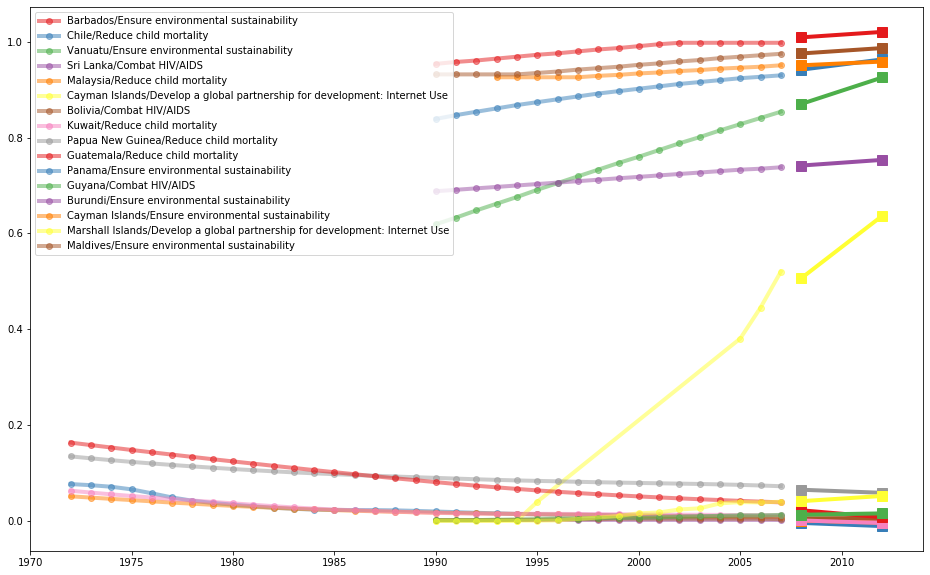

In [11]:
plot_predictions(df_submission_in_data, df_simple_preds, 16)

These results are simplistic but not too bad for most indicators. We could improve easily the results by doing a polynomial regression or another type of more sophisticated regression.  

What we are trying to achieve is to find a correlation between these indicators and all the other indicators present in the dataset, as to improve our predictions since we have a lot of missing data. These predictions using correlations are where the difficulty of this exercise lies.

### Plotting target indicator

#### Plotting one target indicator [Environmental Sustainability (7.8)] for Afghanistan

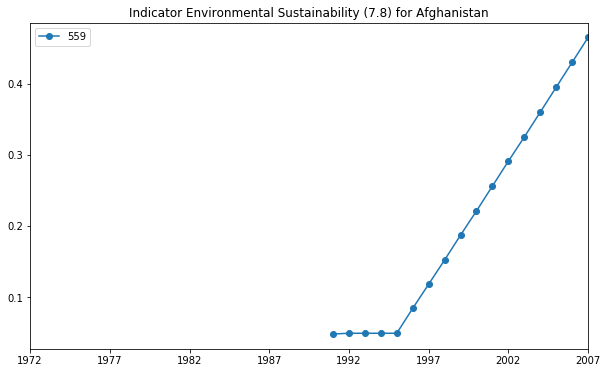

In [12]:
df_afghanistan_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] == "7.8")]
df_afghanistan_7_8_1972_to_2007 = df_afghanistan_7_8.loc[:, "1972":"2007"]
df_afghanistan_7_8_1972_to_2007.T.plot(marker="o", figsize=(10, 6), \
                                       title="Indicator Environmental Sustainability (7.8) for Afghanistan");

#### Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan

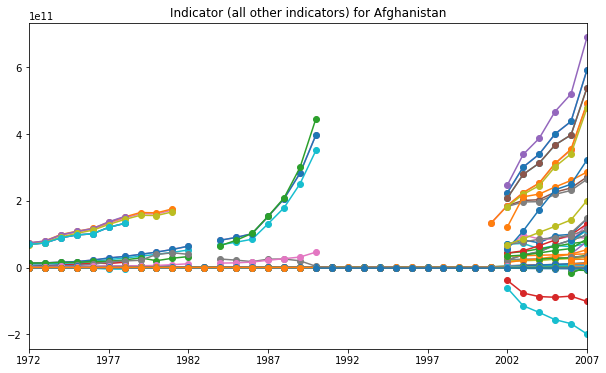

In [13]:
df_afghanistan_not_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] != "7.8")]
df_afghanistan_not_7_8_1972_to_2007 = df_afghanistan_not_7_8.loc[:, "1972":"2007"]
df_afghanistan_not_7_8_1972_to_2007.T.plot(marker="o", figsize=(10, 6), legend=False, \
                                           title="Indicator (all other indicators) for Afghanistan");

#### Plotting all indicators except Environmental Sustainability (7.8) for Afghanistan for 2001 to 2007

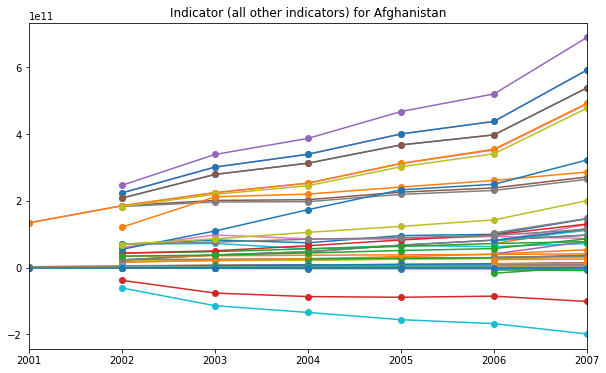

In [14]:
df_afghanistan_not_7_8 = df[ (df["Country_Name"] == "Afghanistan") & (df["Series_Code"] != "7.8")]
df_afghanistan_not_7_8_1972_to_2001 = df_afghanistan_not_7_8.loc[:, "2001":"2007"]
df_afghanistan_not_7_8_1972_to_2001.T.plot(marker="o", legend=False, figsize=(10, 6), \
                                           title="Indicator (all other indicators) for Afghanistan");

#### Enlisting top correlated features against target feature [Environmental Sustainability (7.8)]

In [15]:
df_afghanistan = df[ df["Country_Name"] == "Afghanistan" ]

df_2000_2007 = df_afghanistan.loc[:, "2000":"2007"]
df_2000_2007_clean_index = df_2000_2007.count(axis=1) >= 4

data = df_afghanistan[df_2000_2007_clean_index].set_index('Series_Code').loc[:, "2000":"2007"].T

coeff = data.corr().loc["7.8"].abs()
coeff.sort_values(inplace=True, ascending=False)
coeff.iloc[0:20]

Series_Code
7.8                  1.000000
SH.H2O.SAFE.UR.ZS    0.999991
SH.H2O.SAFE.RU.ZS    0.999980
SP.RUR.TOTL.ZS       0.999972
SP.URB.TOTL.IN.ZS    0.999972
SH.STA.ACSN.UR       0.999958
4.1                  0.999815
SP.DYN.IMRT.IN       0.999794
SP.URB.TOTL          0.999742
SH.STA.ACSN          0.999618
SH.DYN.NMRT          0.999542
SP.DYN.CDRT.IN       0.999375
SP.POP.TOTL          0.999343
EN.POP.DNST          0.999343
SL.TLF.TOTL.IN       0.999190
SP.DYN.LE00.FE.IN    0.999073
SP.DYN.AMRT.FE       0.999012
SP.RUR.TOTL          0.998992
SP.DYN.LE00.IN       0.998971
SP.DYN.AMRT.MA       0.998868
Name: 7.8, dtype: float64

#### Plotting the top correlated indicators for Afghanisthan between 2000 to 2007

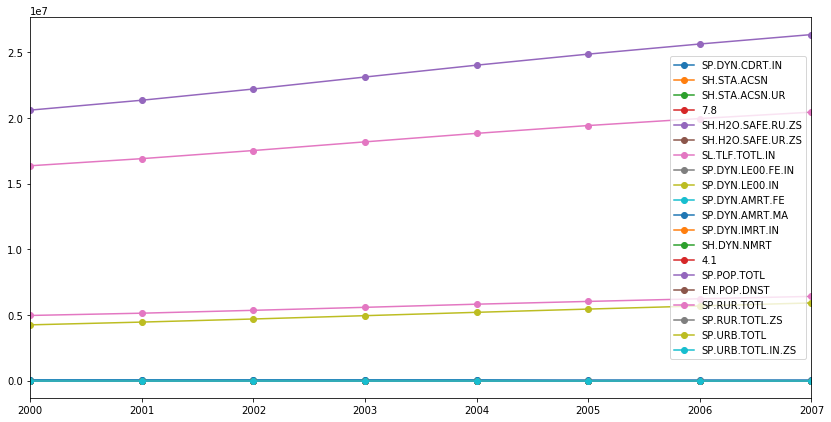

In [16]:
series_code_correlated_to_7_8 = coeff.iloc[0:20].index
df_afghanistan_indicators_correlated_to_7_8 = df_afghanistan[df_afghanistan.Series_Code.isin(series_code_correlated_to_7_8)]
df_afghanistan_indicators_correlated_to_7_8.set_index('Series_Code', inplace=True)
plt.rcParams["figure.figsize"] = (14,7)
df_afghanistan_indicators_correlated_to_7_8.loc[:, "2000":"2007"].T.plot(marker="o", legend=True)
plt.legend(loc=5);

In [17]:
from sklearn.preprocessing import normalize, scale, MinMaxScaler

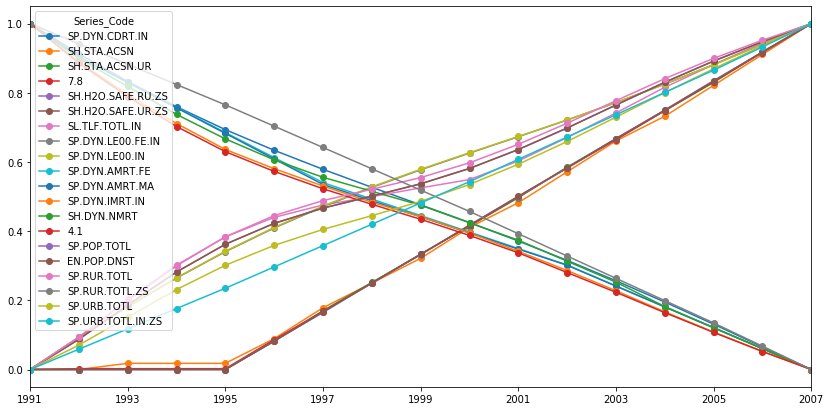

In [18]:
scaled_df = df_afghanistan_indicators_correlated_to_7_8.loc[:,'1972':'2007'].T
# print(scaled_df.shape)
# display(scaled_df.head(20))
scaled_df = scaled_df.dropna()
scaled2_norm_df = pd.DataFrame(normalize(scaled_df, axis=0), columns=scaled_df.columns, index=scaled_df.index)
scaled2_scale_df = pd.DataFrame(scale(scaled_df, axis=0), columns=scaled_df.columns, index=scaled_df.index)
scaled2_MinMax_df = pd.DataFrame(MinMaxScaler().fit_transform(scaled_df), columns=scaled_df.columns, index=scaled_df.index)
# display(scaled_df.head(20))
# scaled2_norm_df.plot(marker="o", legend=True)
# scaled2_scale_df.plot(marker="o", legend=True)
scaled2_MinMax_df.plot(marker="o", legend=True);

In [19]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

In [20]:
def make_prediction(row):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count() < 6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        #linear regression
        regr = LinearRegression()
        regr.fit(years, values)
        
        #predictions
        return regr.predict(np.array(range(2002,2008)).reshape(-1, 1))

In [21]:
%pdb 0
from pdb import set_trace
from sklearn.metrics import mean_squared_error

Automatic pdb calling has been turned OFF


In [22]:
def count_nas(df):
    return df.isna().sum().sum()

In [23]:
df = df_submission_in_data.dropna(subset=true_columns)
df_simple_preds_true_columns = pd.DataFrame(df.apply(make_prediction, axis=1).tolist(), \
                               index=df.index, columns=true_columns)

In [24]:
df_simple_preds.shape

(737, 2)

In [25]:
df_simple_preds_true_columns.shape

(697, 6)

In [26]:
scaled_df.shape

(17, 20)

In [27]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled2_MinMax_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), \
                                            columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [28]:
scaled2_MinMax_df_submission.shape

(148, 36)

In [29]:
scaled2_MinMax_df_dropna = scaled2_MinMax_df_submission.dropna(subset=true_columns)
scaled2_MinMax_df_preds = pd.DataFrame(scaled2_MinMax_df_dropna.apply(make_prediction, axis=1).tolist(), \
                               index=scaled2_MinMax_df_dropna.index, columns=true_columns)

In [30]:
scaled2_MinMax_df_true_columns = scaled2_MinMax_df_dropna[true_columns]
scaled2_MinMax_df_true_columns.shape

(148, 6)

In [31]:
scaled2_MinMax_df_preds.shape

(148, 6)

In [32]:
count_nas(scaled2_MinMax_df_true_columns)

0

In [33]:
scaled2_MinMax_df_true_columns.head(2)

2002      2003      2004      2005      2006      2007
753   0.125452  0.121878  0.119000  0.115870  0.112646  0.109700
3427  0.027856  0.026145  0.024909  0.023618  0.022408  0.021496

In [34]:
count_nas(scaled2_MinMax_df_preds)

0

In [35]:
scaled2_MinMax_df_preds.head(2)

2002      2003      2004      2005      2006      2007
753   0.108071  0.101877  0.095683  0.089488  0.083294  0.077099
3427 -0.014307 -0.021623 -0.028940 -0.036256 -0.043572 -0.050889

In [36]:
def assert_all_finite(X):
    X = np.asanyarray(X)
    return (X.dtype.char in np.typecodes['AllFloat'] and np.isfinite(X.sum())
            and np.isfinite(X).all())

In [37]:
def validate(y_true, y_pred):
    y_true_df = y_true.copy()
    y_pred_df = y_pred.dropna()
    validate = y_true_df.loc[y_pred_df.index][true_columns]
    assert(assert_all_finite(validate.dropna()))
    assert(assert_all_finite(y_pred_df))
    return mean_squared_error(validate.dropna(), y_pred_df)
# should return the dispersion of the errors as well

print(validate(scaled2_MinMax_df_true_columns, scaled2_MinMax_df_preds))

0.0003382664053419799


In [38]:
retained_columns = ['Country_Name', 'Series_Code', 'Series_Name']

In [39]:
df_submission_in_data_dropna = df_submission_in_data.dropna(subset=true_columns)

In [40]:
df_submission_in_data_no_years = df_submission_in_data_dropna[retained_columns]

In [41]:
df_merged = pd.merge(scaled2_MinMax_df_true_columns, df_submission_in_data_no_years, left_index=True, \
                     right_index=True, how='outer', suffixes=('',''))

In [42]:
df_merged.dropna(inplace=True)
df_merged.shape

(148, 9)

In [43]:
assert(df_submission_in_data.shape[0] == df_simple_preds.shape[0])

In [44]:
# plot_predictions(df_submission_in_data, df_simple_preds, 16)

In [45]:
assert(df_merged.shape[0] == scaled2_MinMax_df_preds.shape[0])

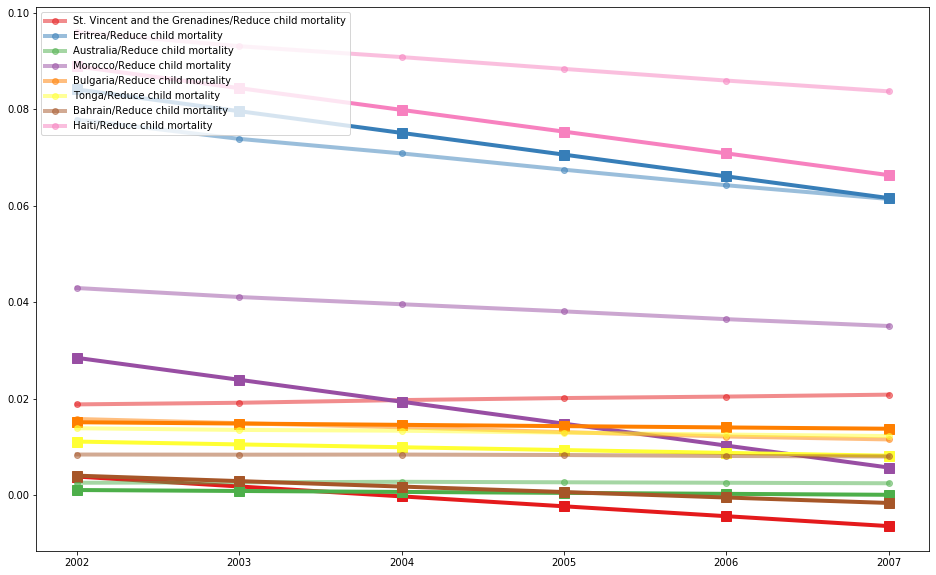

In [46]:
plot_predictions(df_merged, scaled2_MinMax_df_preds, 8)

### Polynomial model setup (12/06/2019)

In [47]:
# from sklearn.model_selection import train_test_split
# X = scaled2_norm_df
# print(X.shape)
# y = submission_codes
# print(y.shape)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [48]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

In [49]:
def make_prediction(row, model):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count()<6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        model.fit(years, values)
        
        #predictions
        return model.predict(np.array(range(2002,2008)).reshape(-1, 1))

#### Polynomial regression baseline

In [50]:
pred_columns = [str(item) + "_pred" for item in np.array(range(2002,2008))]
true_columns = [str(item) for item in range(2002,2008)]

In [51]:
def make_prediction(row, model):
    training_data = row.loc['1972':'2002']
    test_data = row.loc['2002':'2007']
    
    nbr_data_points = training_data.count()
    if test_data.count()<6 or training_data.count() < 6 :
        return  [None]*6
    else:
        years = training_data.dropna().index.values.astype(np.int).reshape(-1, 1)
        values = training_data.dropna().values
        
        model.fit(years, values)
        
        #predictions
        return model.predict(np.array(range(2002,2008)).reshape(-1, 1))

In [52]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [53]:
model = LinearRegression()

In [54]:
df = df_submission_in_data.dropna(subset=true_columns)
# df.loc[:,'1972':'2007'].head()
df=df.loc[:,'2005':'2007']
df=df.iloc[0:2,:]
display(df.head())
transformer = PolynomialFeatures(degree=1)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
transformer = PolynomialFeatures(degree=2,interaction_only=False)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
transformer = PolynomialFeatures(degree=2,interaction_only=True)
df_poly=transformer.fit_transform(df.T)
print(df_poly)
# df_simple_preds_true_columns = pd.DataFrame(df.apply(make_prediction, args=(model,),axis=1).tolist(),\
#                                index=df.index, columns=true_columns)

2005      2006   2007
559  0.395000  0.430000  0.465
618  0.012241  0.021071  0.019

[[1.         0.395      0.01224148]
 [1.         0.43       0.02107124]
 [1.         0.465      0.019     ]]
[[1.00000000e+00 3.95000000e-01 1.22414808e-02 1.56025000e-01
  4.83538493e-03 1.49853853e-04]
 [1.00000000e+00 4.30000000e-01 2.10712365e-02 1.84900000e-01
  9.06063168e-03 4.43997006e-04]
 [1.00000000e+00 4.65000000e-01 1.90000000e-02 2.16225000e-01
  8.83500000e-03 3.61000000e-04]]
[[1.         0.395      0.01224148 0.00483538]
 [1.         0.43       0.02107124 0.00906063]
 [1.         0.465      0.019      0.008835  ]]


In [55]:
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
# tried degree 3 but did not look better

In [56]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled_df_submission = scaled_df_submission.dropna(subset=true_columns)
scaled_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), \
                                    columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [57]:
scaled_df_submission_preds = pd.DataFrame(scaled_df_submission.apply(make_prediction, args=(model,),axis=1).tolist(),\
                               index=scaled_df_submission.index, columns=true_columns)

In [58]:
print(validate(scaled_df_submission, scaled_df_submission_preds))

0.000266447986779287


In [59]:
df_submission_in_data_dropna = df_submission_in_data.dropna(subset=true_columns)
df_submission_in_data_no_years = df_submission_in_data_dropna[retained_columns]
df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, \
                     right_index=True, how='outer', suffixes=('',''))
df_merged.dropna(subset=true_columns,inplace=True)

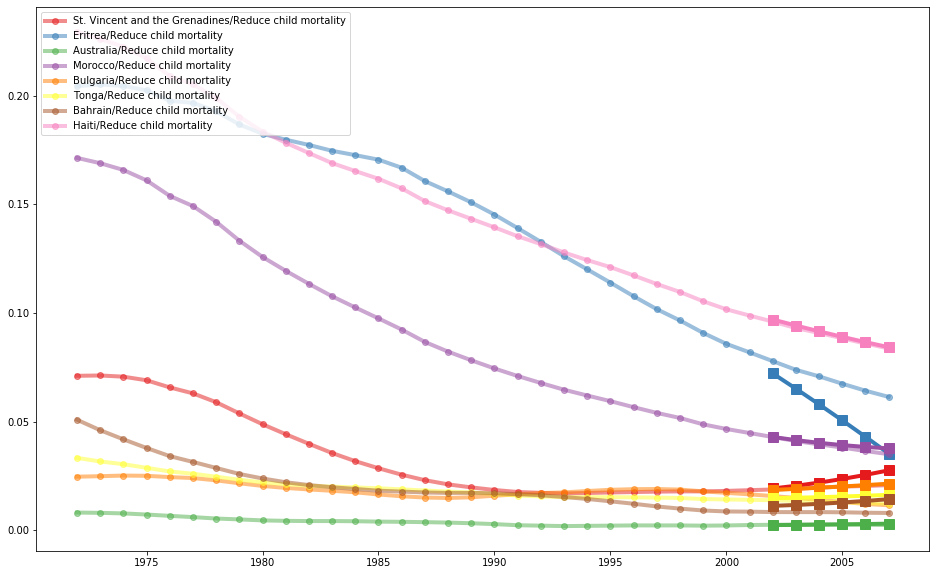

In [60]:
# df_merged = pd.merge(scaled_df_submission, df_submission_in_data_no_years, left_index=True, right_index=True, how='outer', suffixes=('',''))
plot_predictions(df_merged, scaled_df_submission_preds, 8)

## Using multivariate indicators
### LSTM

attempt to use https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [61]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [62]:
scaler = MinMaxScaler()
scaled_df_submission = df_submission_in_data.loc[:,'1972':'2007']
scaled_df_submission = scaled_df_submission.dropna()
scaled_df_submission = pd.DataFrame(scaler.fit_transform(scaled_df_submission), \
                                    columns=scaled_df_submission.columns, index=scaled_df_submission.index)

In [112]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('ind%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('ind%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('int%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [113]:
print(scaled_df_submission.shape)
values=series_to_supervised(scaled_df_submission.T,1,1).values

(148, 36)


In [114]:
# values[['var1(t-1)','var1(t)']]

In [115]:

print(values.shape)
# split into train and test sets
n_train_hours = int(values.shape[0]*0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 

(35, 296)
(24, 1, 295) (24,) (11, 1, 295) (11,)


In [122]:
scaled_df_submission.T.head()

753       3427      10112     14123     15460     18134     19471   \
1972  0.292671  0.225536  0.059710  0.008250  0.016294  0.019903  0.050944   
1973  0.290754  0.224442  0.059129  0.008120  0.015823  0.021028  0.046117   
1974  0.287541  0.221186  0.057865  0.007862  0.014885  0.022014  0.041931   
1975  0.282554  0.214720  0.055462  0.007339  0.013315  0.022646  0.037953   
1976  0.274029  0.203553  0.051717  0.006737  0.011712  0.022801  0.034202   

        20808     22145     24819   ...    269490    270827    272164  \
1972  0.214604  0.031866  0.010003  ...  0.071982  0.008044  0.009591   
1973  0.216634  0.030398  0.009577  ...  0.065271  0.008120  0.009369   
1974  0.217831  0.029037  0.009120  ...  0.059018  0.008177  0.009225   
1975  0.216712  0.027469  0.008702  ...  0.052946  0.008073  0.008912   
1976  0.212052  0.025600  0.008084  ...  0.046639  0.007670  0.008395   

        273501    276175    277512    278849    282860    284197    285534  
1972  0.040425  0.088791  0.048160  0.070847  0.296074  0.162732  0.099516  
1973  0.043098  0.085675  0.047262  0.070268  0.288464  0.159795  0.100666  
1974  0.046648  0.082918  0.046438  0.069815  0.279889  0.157346  0.101892  
1975  0.048962  0.079891  0.045188  0.068673  0.269029  0.154749  0.102537  
1976  0.048401  0.075762  0.043219  0.066642  0.254337  0.151732  0.101776  

[5 rows x 148 columns]

In [127]:
#print(scaled_df_submission.T.iloc[0].values)
#print(scaled_df_submission.T.iloc[1].values[50:])
print()
print(train_X[1][0])
print()
print(train_y[0])


[0.29075432 0.22444193 0.05912942 0.00811988 0.01582336 0.02102842
 0.04611678 0.21663435 0.03039752 0.0095773  0.25254923 0.24682367
 0.20559964 0.09806322 0.11378248 0.02498426 0.30574488 0.24318013
 0.13814214 0.18644504 0.00759938 0.19529363 0.25057131 0.06495908
 0.0864039  0.07745121 0.20539144 0.23703817 0.13751753 0.0483029
 0.21507284 0.02227763 0.00239432 0.03487386 0.10222726 0.11888344
 0.22277632 0.13793393 0.20518323 0.23506025 0.04361835 0.00229022
 0.00447635 0.28107292 0.01197162 0.18873526 0.02238173 0.15219578
 0.31542628 0.06454267 0.22610755 0.12190237 0.03164673 0.00249843
 0.19633464 0.14345129 0.17572263 0.09108845 0.0097855  0.01665617
 0.04039122 0.00343534 0.06797801 0.07193385 0.12866894 0.12221467
 1.         0.02477606 0.04892751 0.10826513 0.04642908 0.15667213
 0.26243883 0.1055585  0.01280443 0.00749528 0.15313269 0.31948622
 0.0379969  0.22360913 0.38007305 0.01249213 0.06985183 0.18009487
 0.07037233 0.08879822 0.04882341 0.16895606 0.25900349 0.1534

Train on 24 samples, validate on 11 samples
Epoch 1/50
 - 1s - loss: 0.1685 - val_loss: 0.1346
Epoch 2/50
 - 0s - loss: 0.1020 - val_loss: 0.0904
Epoch 3/50
 - 0s - loss: 0.0356 - val_loss: 0.0462
Epoch 4/50
 - 0s - loss: 0.0358 - val_loss: 0.0242
Epoch 5/50
 - 0s - loss: 0.0628 - val_loss: 0.0181
Epoch 6/50
 - 0s - loss: 0.0713 - val_loss: 0.0223
Epoch 7/50
 - 0s - loss: 0.0636 - val_loss: 0.0345
Epoch 8/50
 - 0s - loss: 0.0464 - val_loss: 0.0512
Epoch 9/50
 - 0s - loss: 0.0268 - val_loss: 0.0700
Epoch 10/50
 - 0s - loss: 0.0148 - val_loss: 0.0829
Epoch 11/50
 - 0s - loss: 0.0297 - val_loss: 0.0871
Epoch 12/50
 - 0s - loss: 0.0368 - val_loss: 0.0846
Epoch 13/50
 - 0s - loss: 0.0339 - val_loss: 0.0766
Epoch 14/50
 - 0s - loss: 0.0230 - val_loss: 0.0647
Epoch 15/50
 - 0s - loss: 0.0123 - val_loss: 0.0535
Epoch 16/50
 - 0s - loss: 0.0189 - val_loss: 0.0466
Epoch 17/50
 - 0s - loss: 0.0245 - val_loss: 0.0439
Epoch 18/50
 - 0s - loss: 0.0263 - val_loss: 0.0454
Epoch 19/50
 - 0s - loss: 0.0

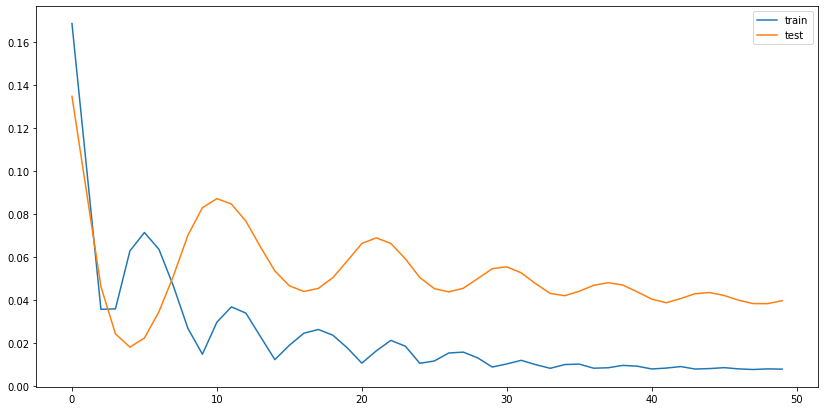

In [118]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [119]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (11,295) (36,) (11,295) 